In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/local/opt/python@3.13/bin/python3.13
3.13.3 (main, Apr  8 2025, 13:54:08) [Clang 17.0.0 (clang-1700.0.13.3)]
sys.version_info(major=3, minor=13, micro=3, releaselevel='final', serial=0)


# A Quick Tutorial of Taking Numerical Derivative of Noisy Data with PyNumDiff

This notebook walks through each of the methods implemented in PyNumDiff.

### Notations:
  * dt: (float) time step
  * x: (np.array with length N) the noisy time series you want to differentiate
  * x_hat: (np.array like x) the smoothed estimate of x
  * x_truth: (np.array like x) the true value of x (which is accessible when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array like x) the estimate of the derivative of x
  * dxdt_truth: (np.array like x) the true value of dxdt (which is accessible when the data is simulated, and used for plotting purposes only)

In [2]:
import os, sys

# local import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pynumdiff
from pynumdiff.utils import simulate, evaluate

## 0. Simulate synthetic data

### PyNumDiff comes with 6 different toy problems:
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* linear_autonomous: (linear) linear time invariant system: dx/dt = Ax  
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

In [3]:
# noise is generated using np.random, e.g. 'normal', 'uniform', 'poisson'
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.1]  # mean and std

# time step size and time series length in TIME
dt = 0.01
duration = 4

In [4]:
x, x_truth, dxdt_truth, _ = simulate.pi_control(duration=duration, dt=dt, 
                                                noise_type=noise_type, noise_parameters=noise_parameters)

## 1. Finite Difference

### 1.1 FD: First Order

RMS error in velocity:  14.166320258514574


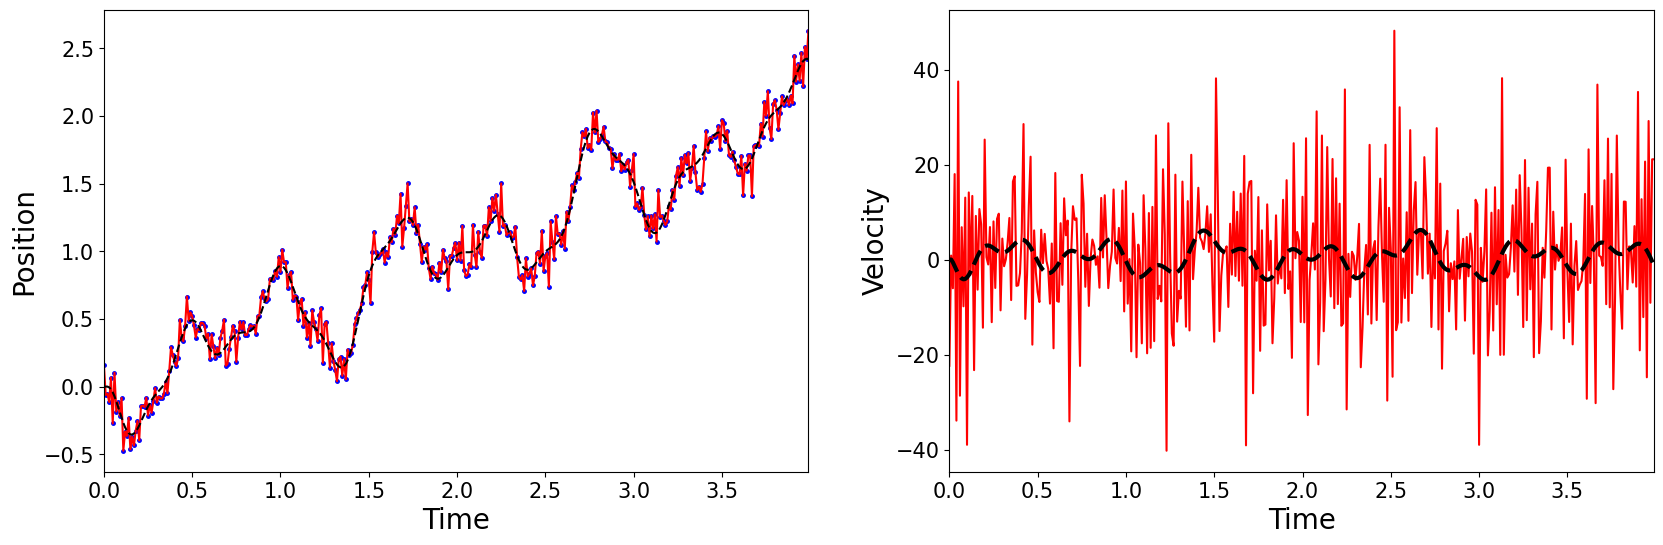

In [5]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.2 FD: Iterated First Order

Note this one causes a nasty shift, because the FD formula isn't centered.

RMS error in velocity:  4.622819137028306


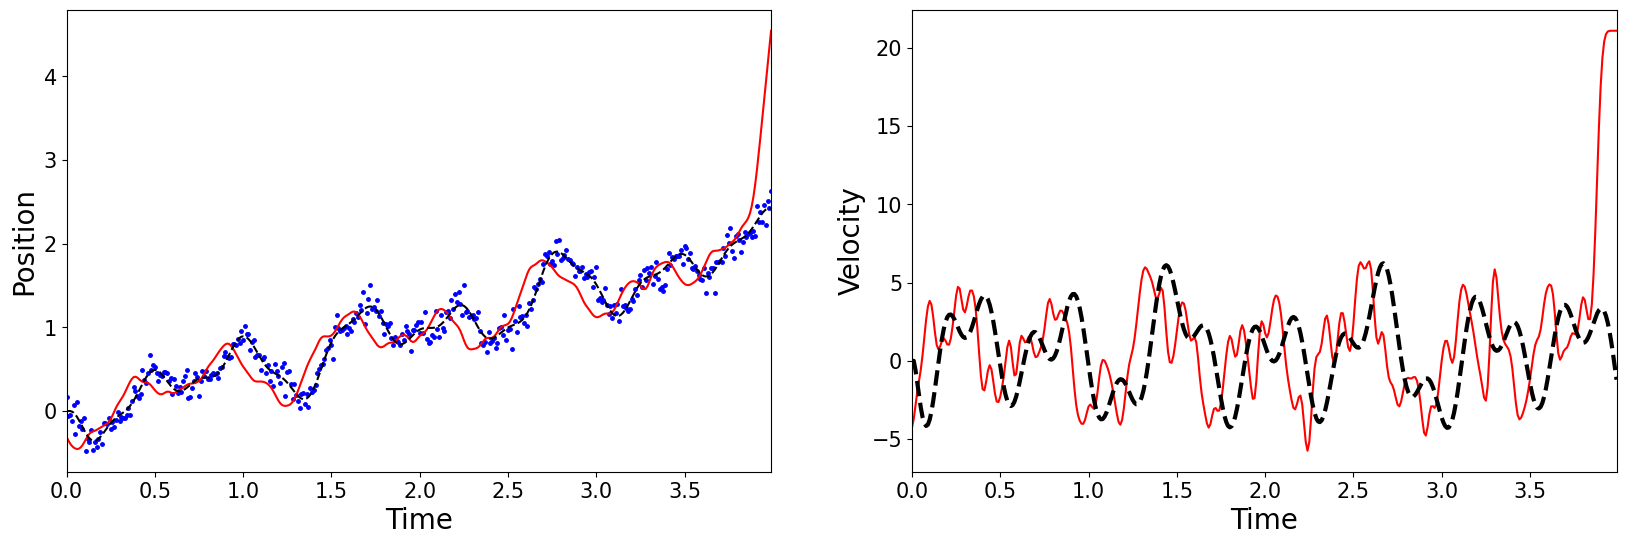

In [6]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt, num_iterations=20)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.3 FD: Second Order

Note the extra blowup at the edges. This is because the FD formulas for the edges have large constants in the numerator, which amplify noise.

RMS error in velocity:  7.239276254626786


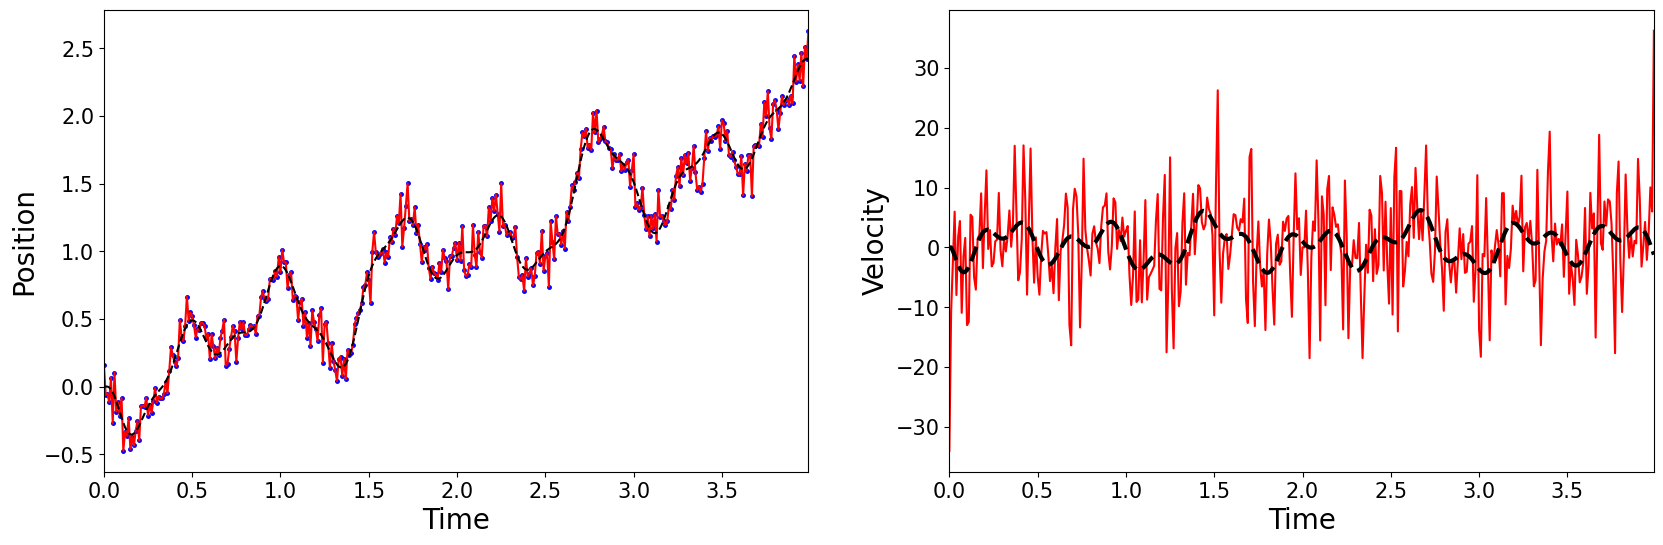

In [7]:
x_hat, dxdt_hat = pynumdiff.finite_difference.second_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.4 FD: Iterated Second Order

RMS error in velocity:  1.044268940210492


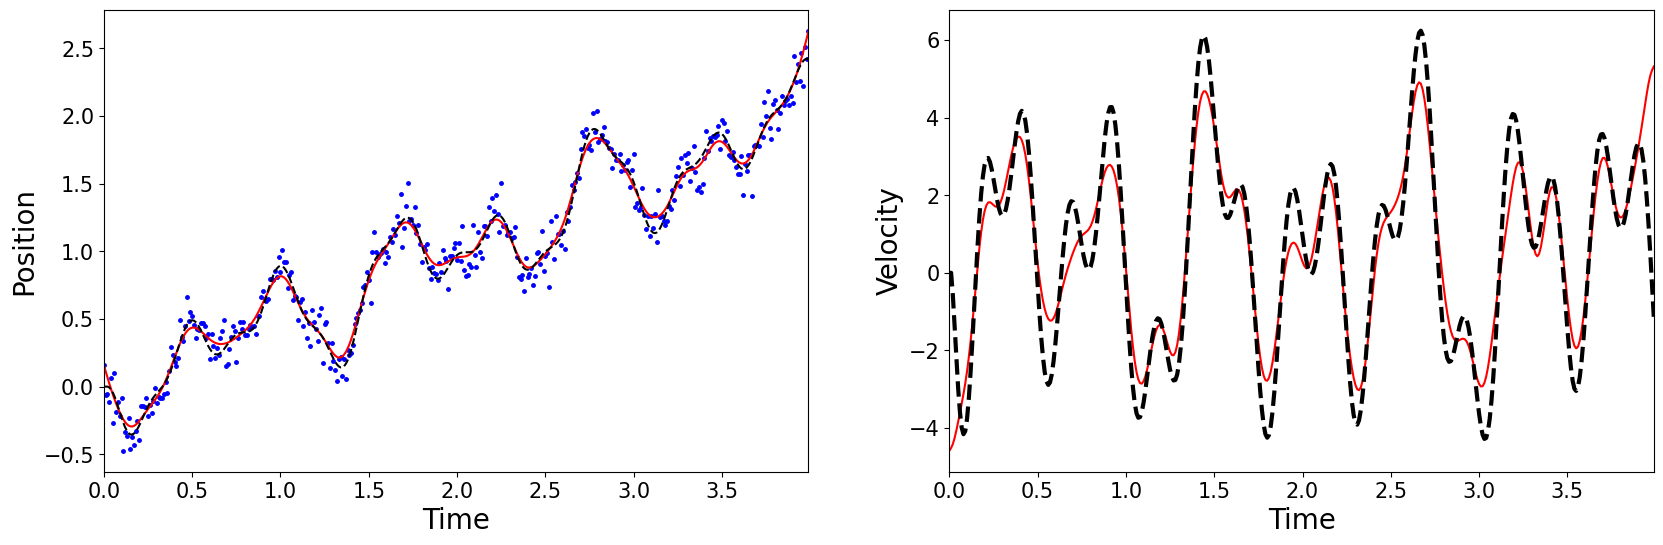

In [8]:
x_hat, dxdt_hat = pynumdiff.finite_difference.second_order(x, dt, num_iterations=50)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.5 FD: Fourth Order

Note the extra blowup at the edges. This is because the FD formulas for the edges have large constants in the numerator, which amplify noise.

RMS error in velocity:  10.80909614066847


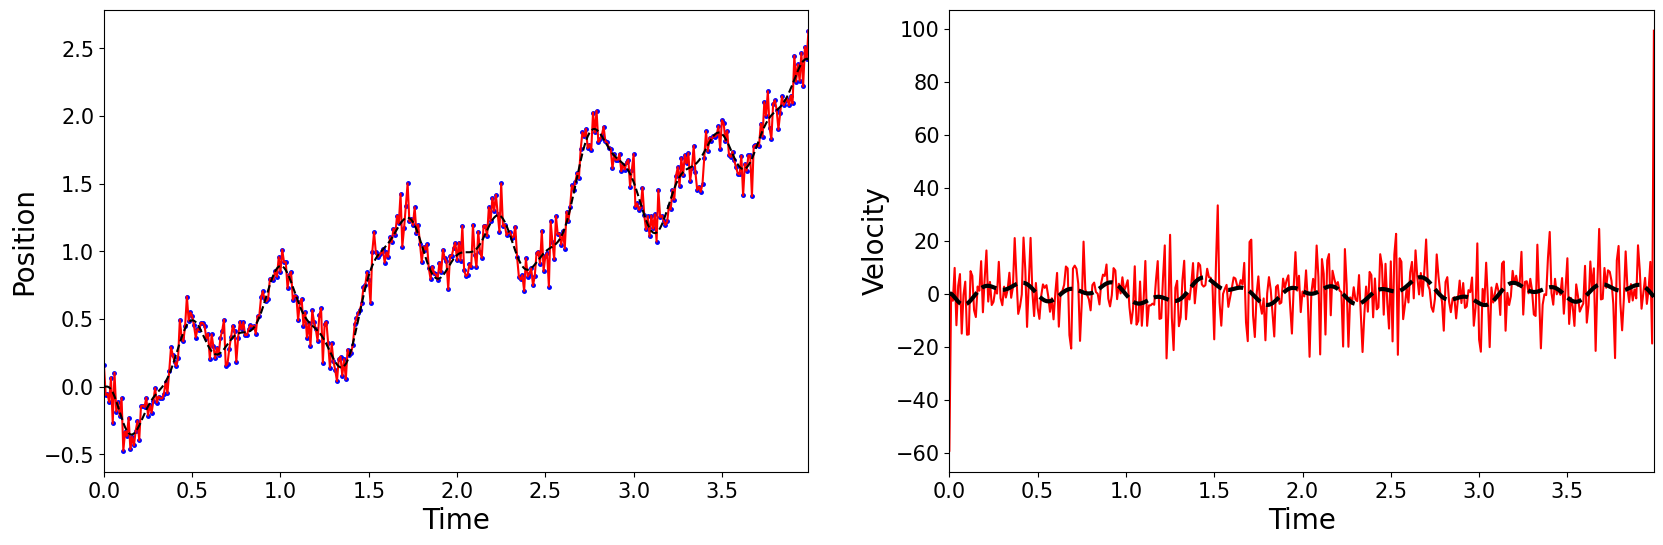

In [9]:
x_hat, dxdt_hat = pynumdiff.finite_difference.fourth_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.6 FD: Iterated Fourth Order

RMS error in velocity:  0.7311640718292198


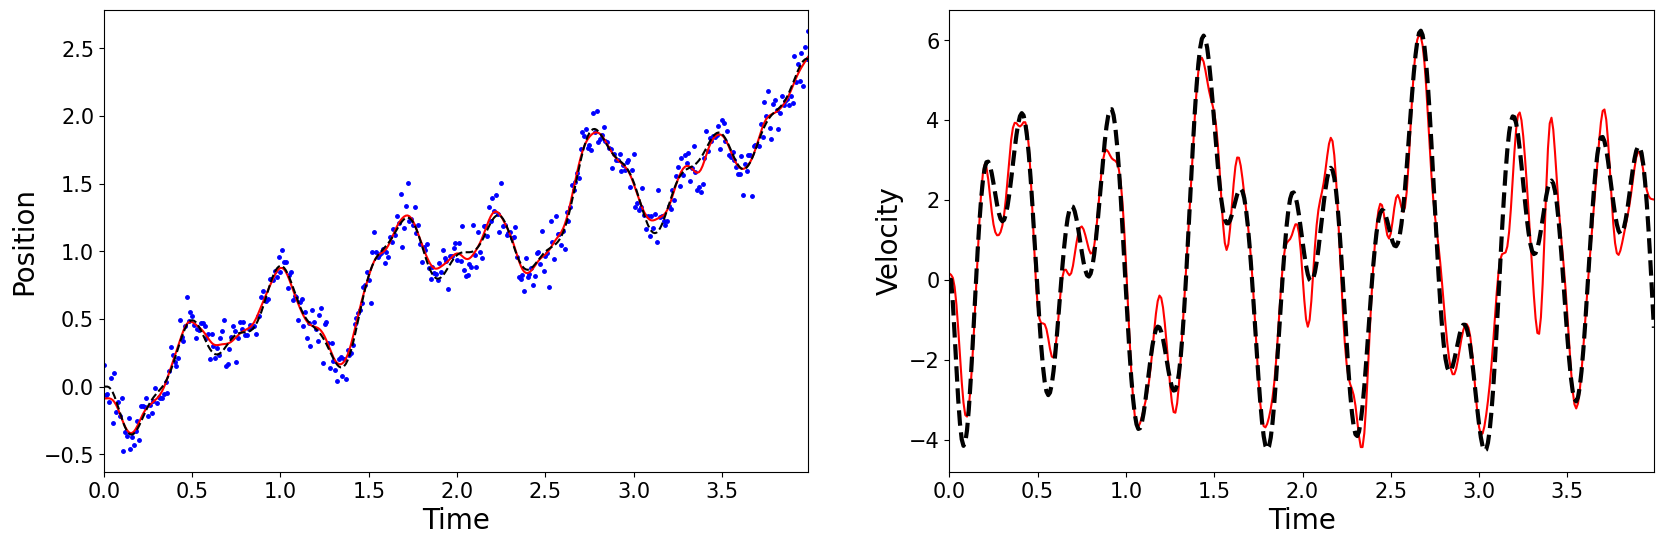

In [10]:
x_hat, dxdt_hat = pynumdiff.finite_difference.fourth_order(x, dt, num_iterations=50)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 2. Smooth Finite Difference

### 2.1 Smooth Finite Difference: Median smoothing

RMS error in velocity:  1.8027403805684288


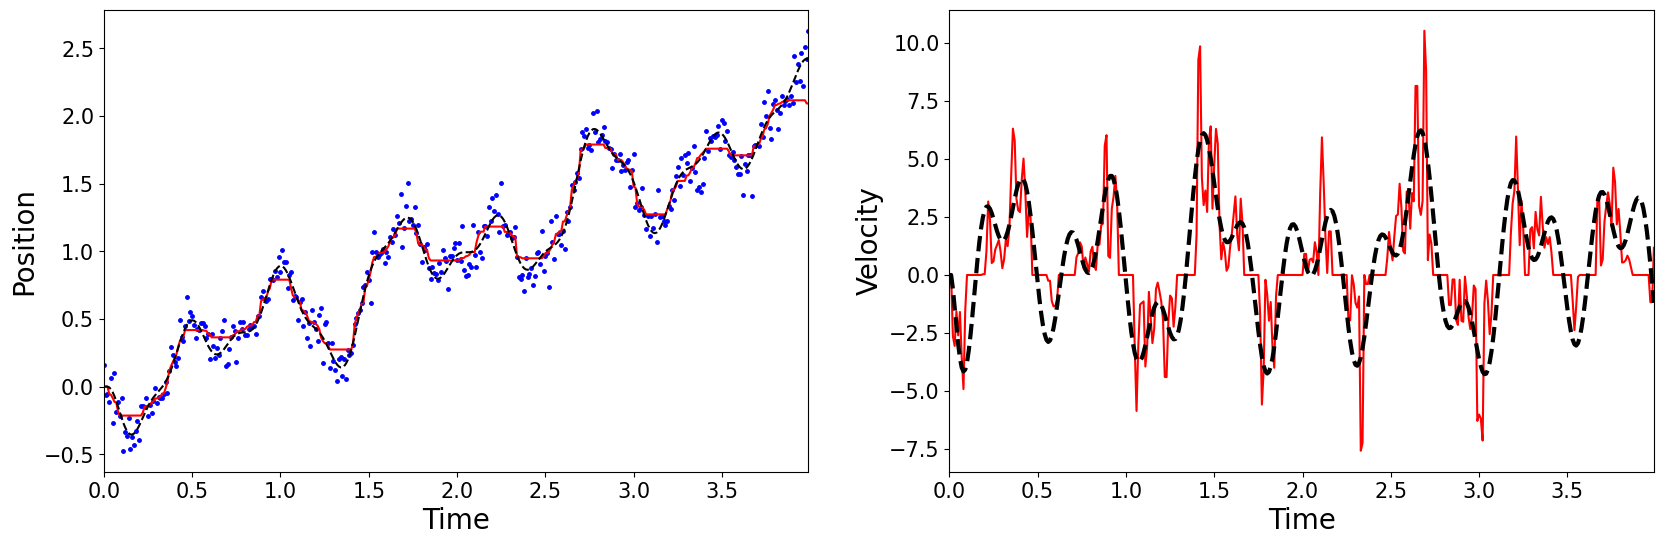

In [11]:
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.mediandiff(x, dt, window_size=20, num_iterations=4)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.2 Smooth Finite Difference: Mean smoothing

RMS error in velocity:  1.3554039555739534


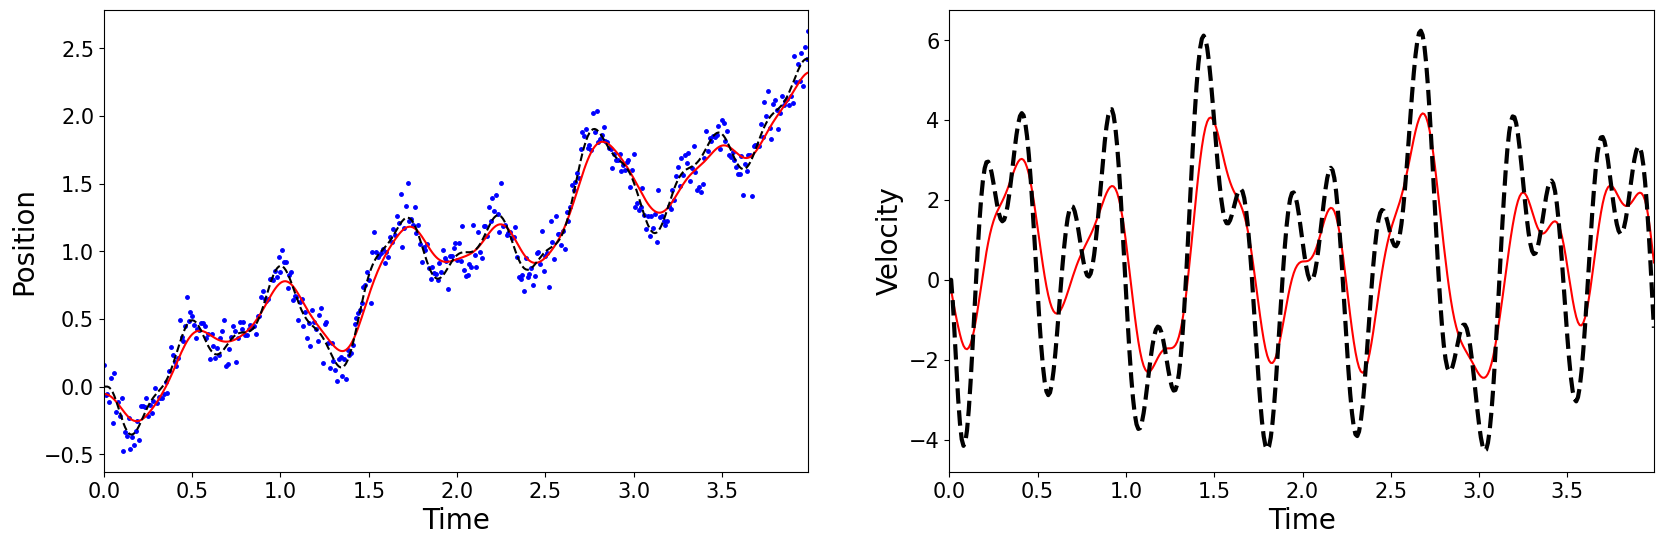

In [12]:
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.meandiff(x, dt, window_size=10, num_iterations=5)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.3 Smooth Finite Difference: Gaussian smoothing

RMS error in velocity:  0.6945135058306626


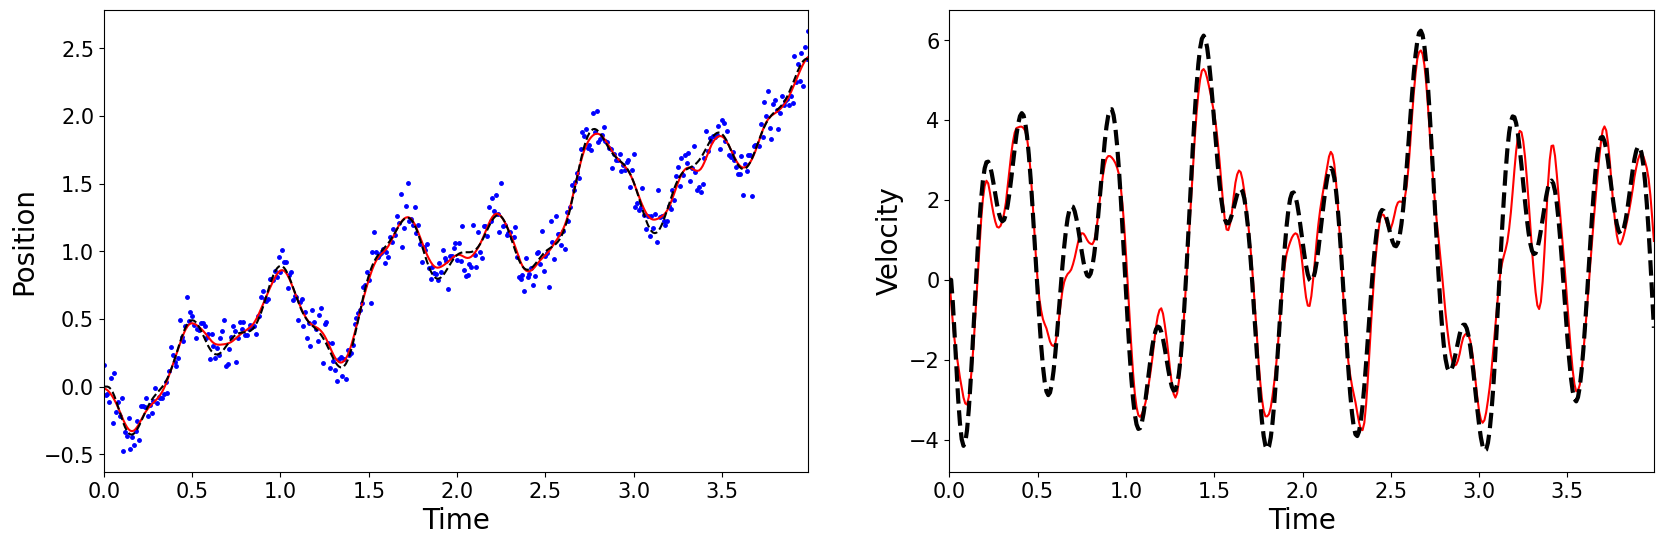

In [13]:
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.gaussiandiff(x, dt, window_size=20)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.4 Smooth Finite Difference: Friedrichs smoothing

RMS error in velocity:  1.290895731508224


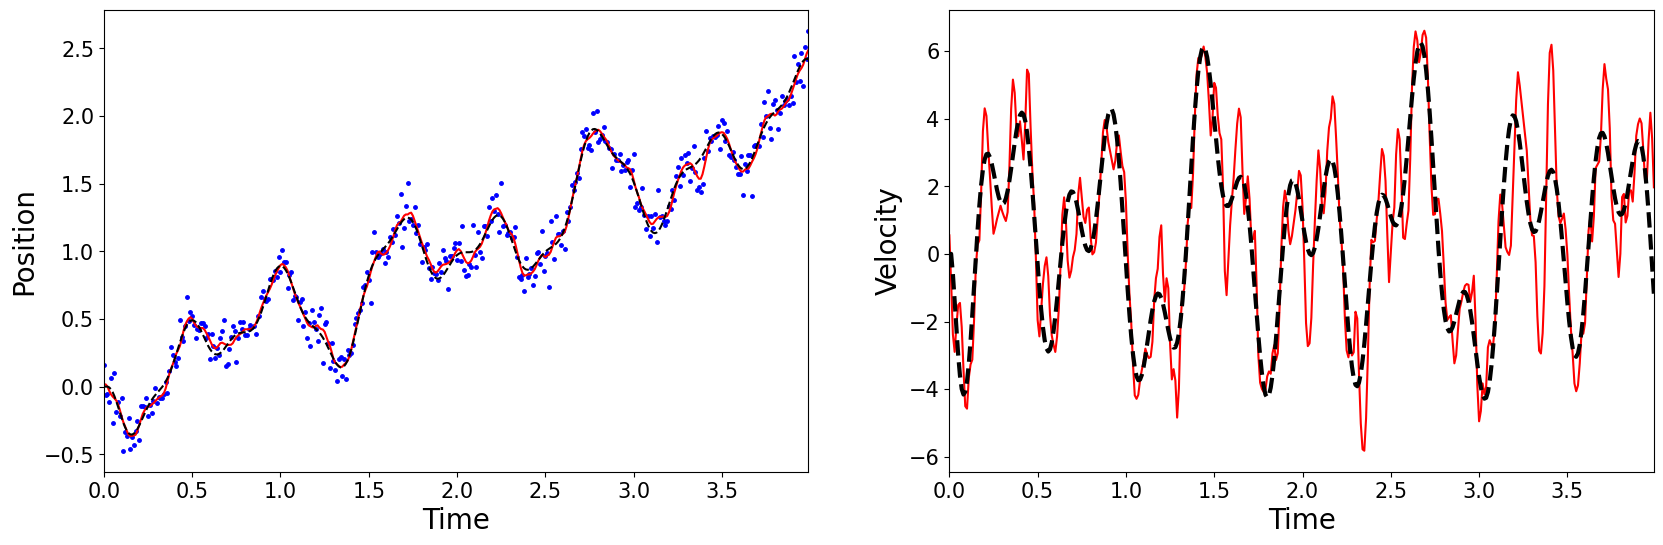

In [14]:
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.friedrichsdiff(x, dt, window_size=10)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.5 Smooth Finite Difference: Butterworth smoothing

RMS error in velocity:  0.9379296282377043


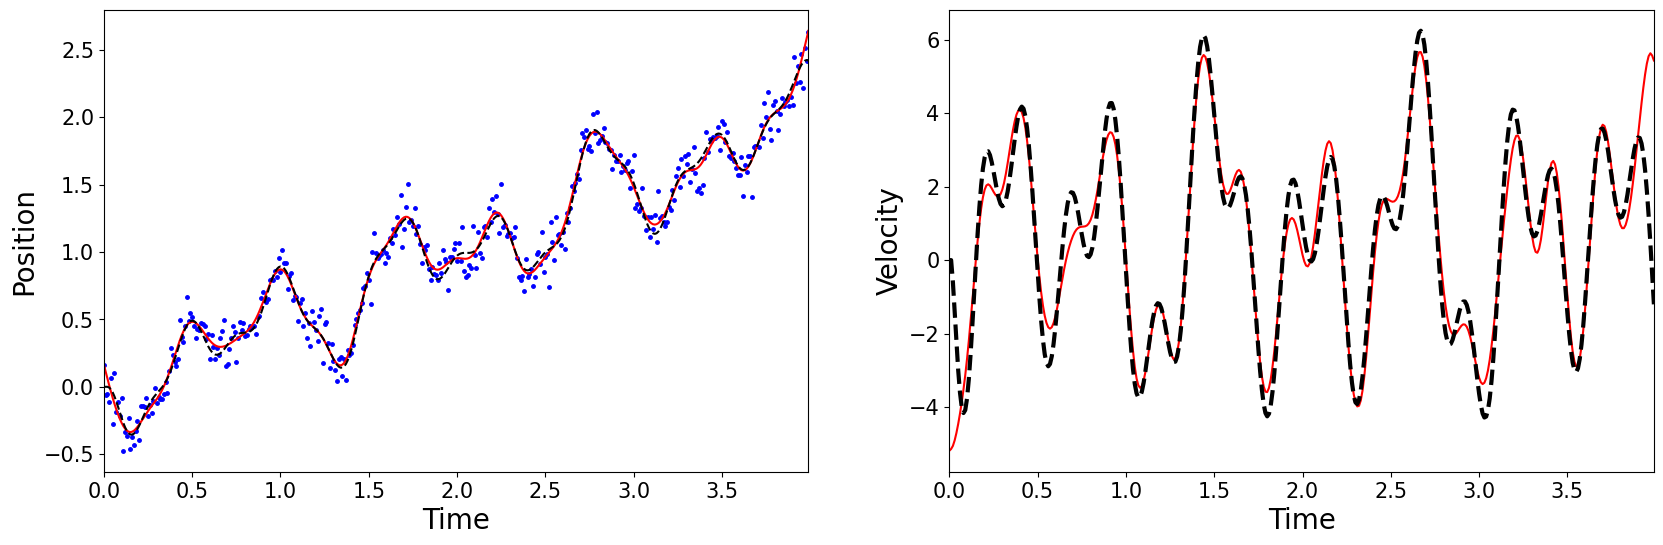

In [15]:
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.butterdiff(x, dt, filter_order=3, cutoff_freq=0.09)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.6 Smooth Finite Difference: Spline smoothing

RMS error in velocity:  1.8799693791327203


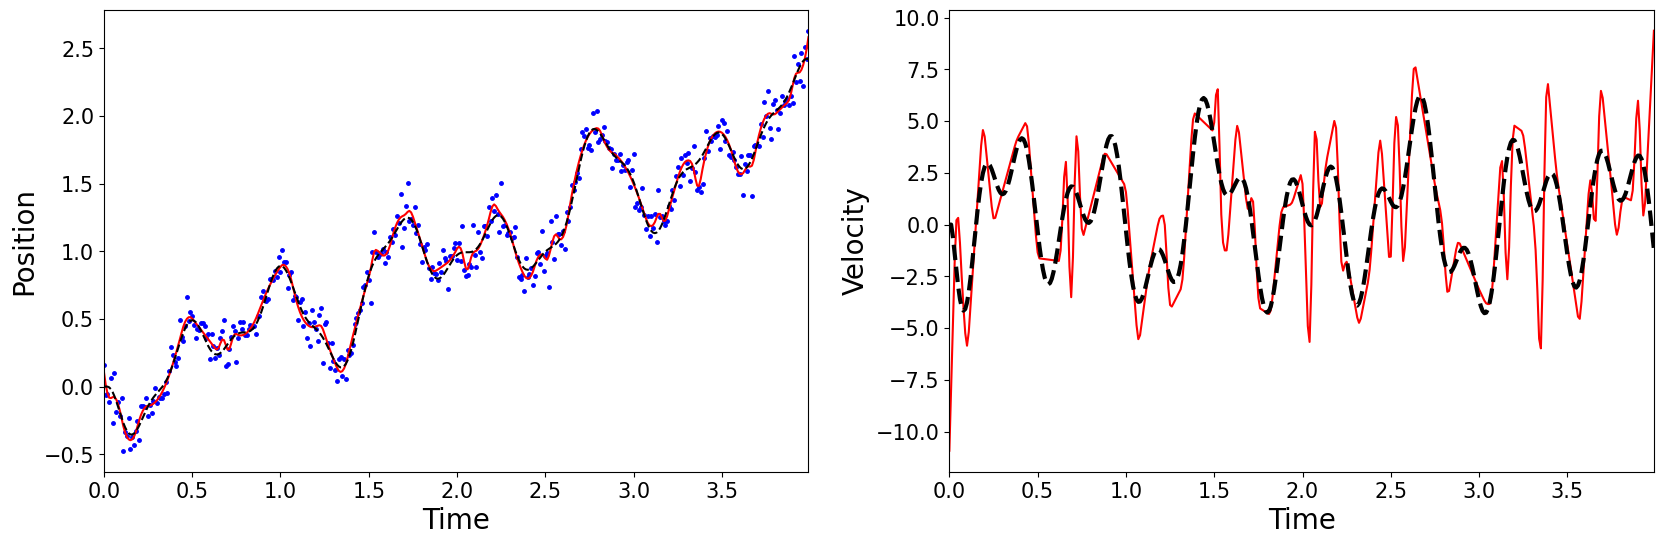

In [16]:
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.splinediff(x, dt, order=2, s=3)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 3. Total Variation Regularization

### 3.1 Iterative Total Variation Regularization (regularized velocity)

RMS error in velocity:  0.9850440161849315


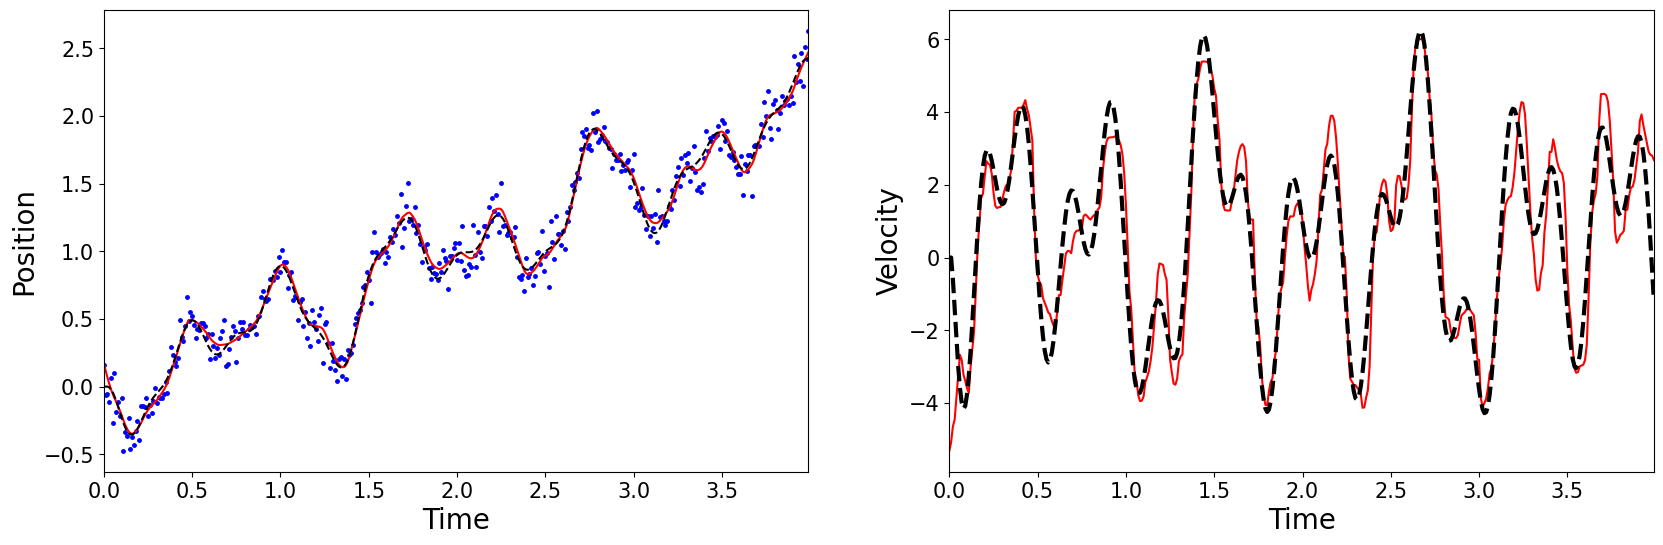

In [17]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.iterative_velocity(x, dt, num_iterations=1, gamma=0.001)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.2 Convex Total Variation Regularization: regularize velocity

RMS error in velocity:  1.0385732535921235


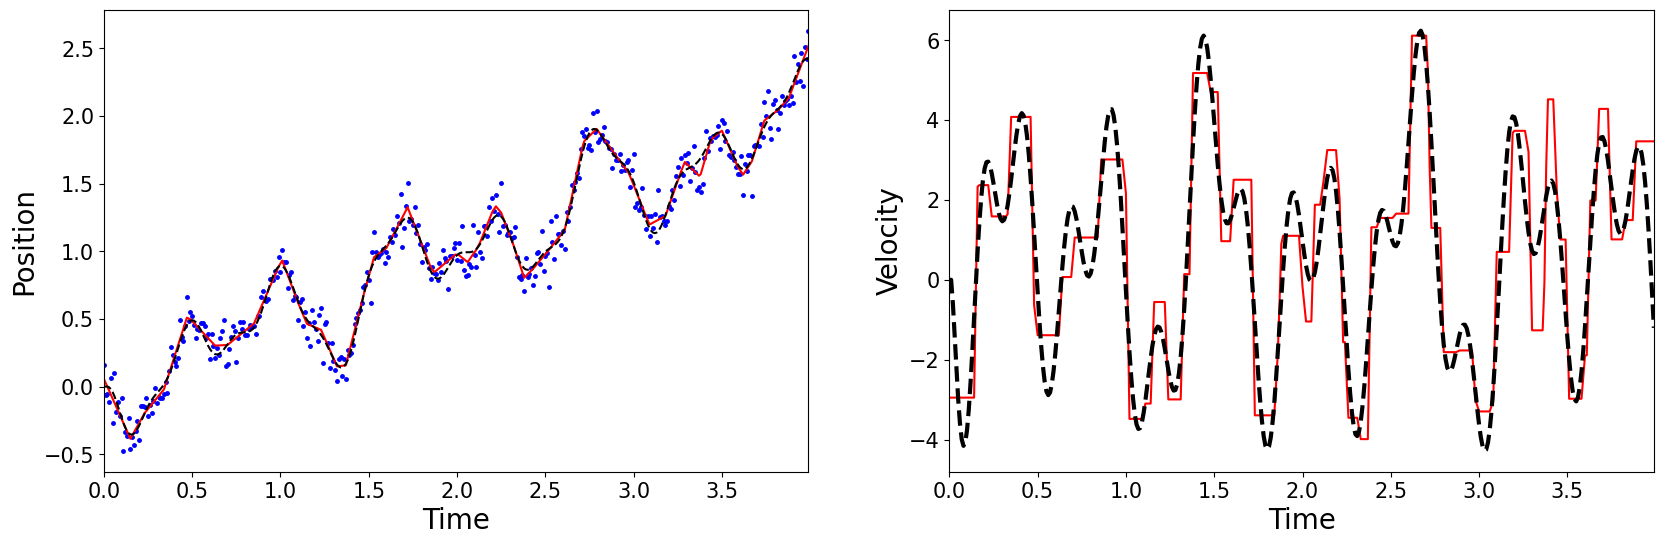

In [18]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.velocity(x, dt, gamma=1)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.3 Convex Total Variation Regularization: regularize acceleration

RMS error in velocity:  1.0426247383047635


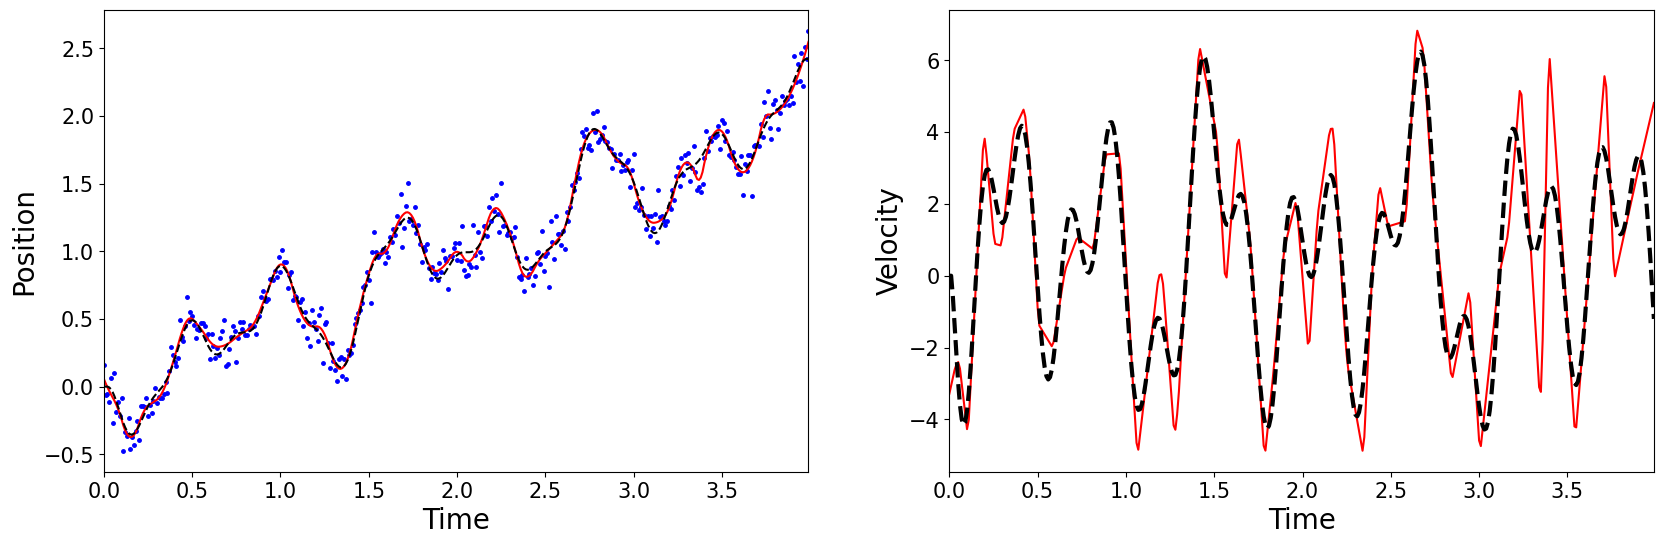

In [19]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.acceleration(x, dt, gamma=1)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.4  Convex Total Variation Regularization: regularize jerk

RMS error in velocity:  0.7975753206327975


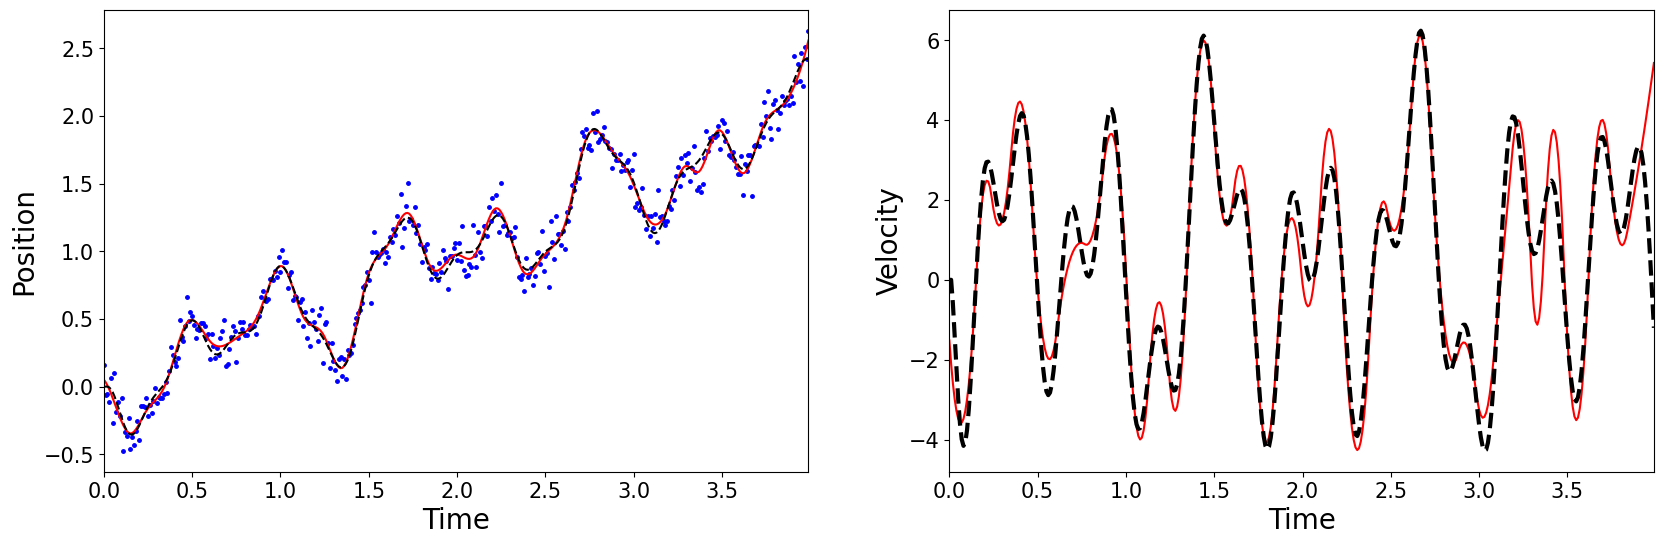

In [20]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.jerk(x, dt, gamma=10)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.5 Convex Total Variation Regularization: regularize acceleration with gaussian smoothing

RMS error in velocity:  0.9294085448597158


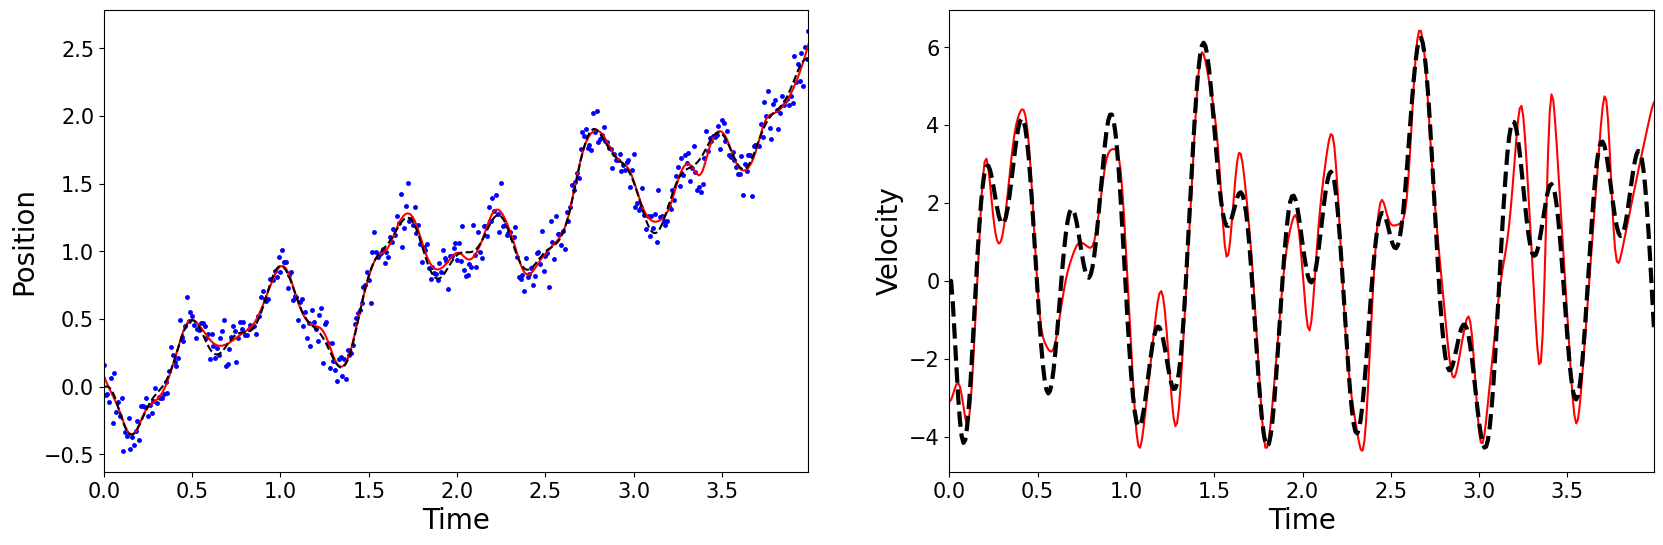

In [21]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.smooth_acceleration(x, dt, gamma=1, window_size=10)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.6 Convex Total Variation Regularization: regularize jerk in a sliding window

RMS error in velocity:  1.0001840163517715


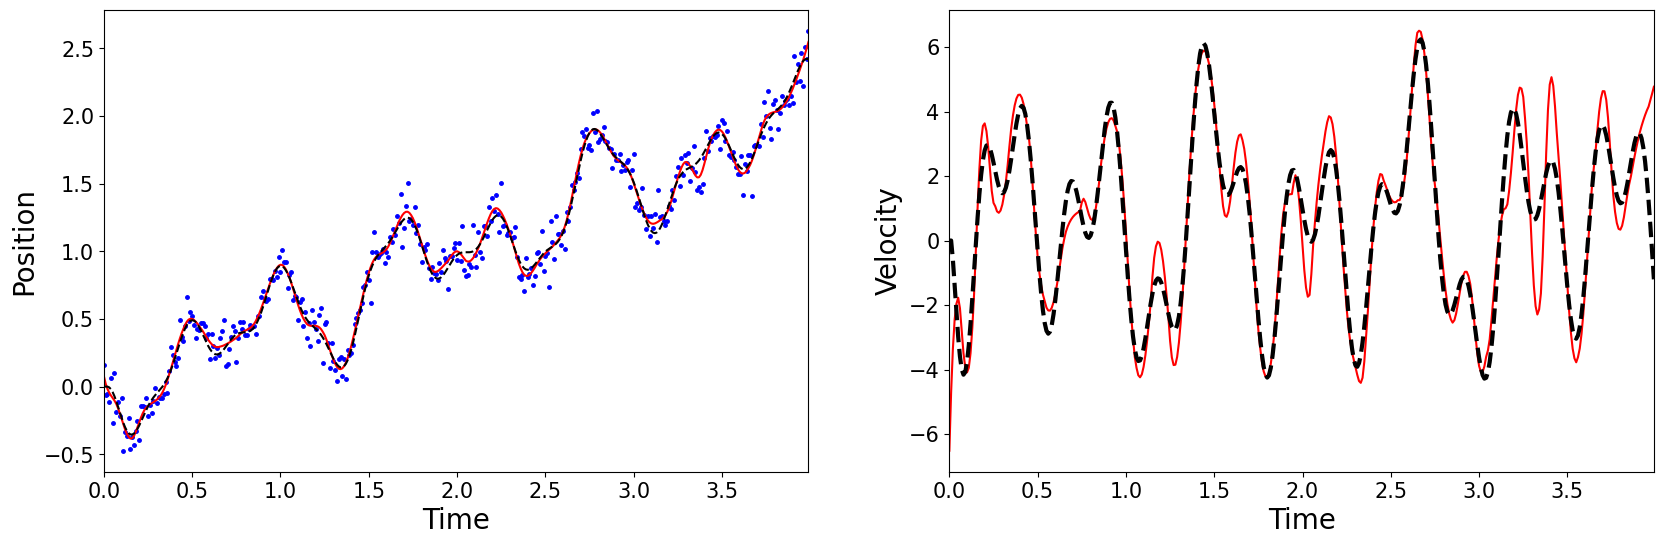

In [22]:
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.jerk_sliding(x, dt, gamma=10, window_size=51)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 4. Linear Models

### 4.1 Linear Models: Spectral derivative

RMS error in velocity:  0.6275358411668934


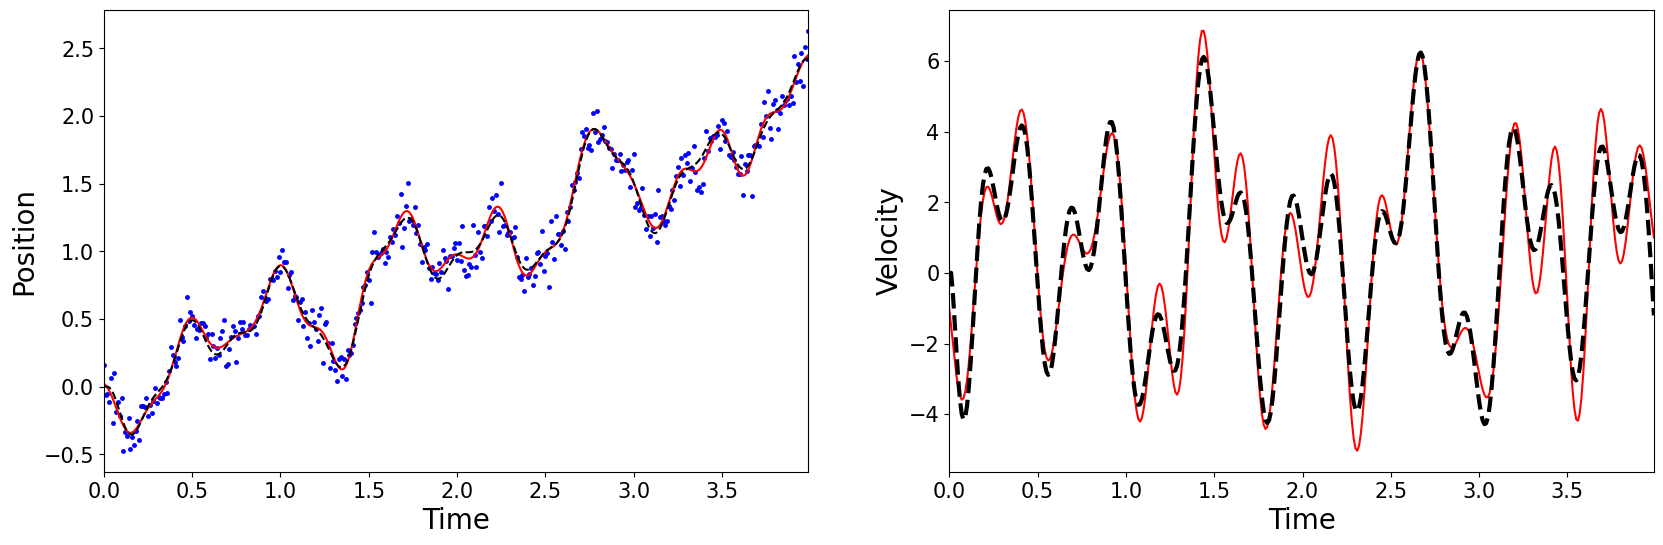

In [23]:
x_hat, dxdt_hat = pynumdiff.linear_model.spectraldiff(x, dt, high_freq_cutoff=0.05)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.2 Linear Models: Sliding polynomial fit

RMS error in velocity:  1.0329161242812532


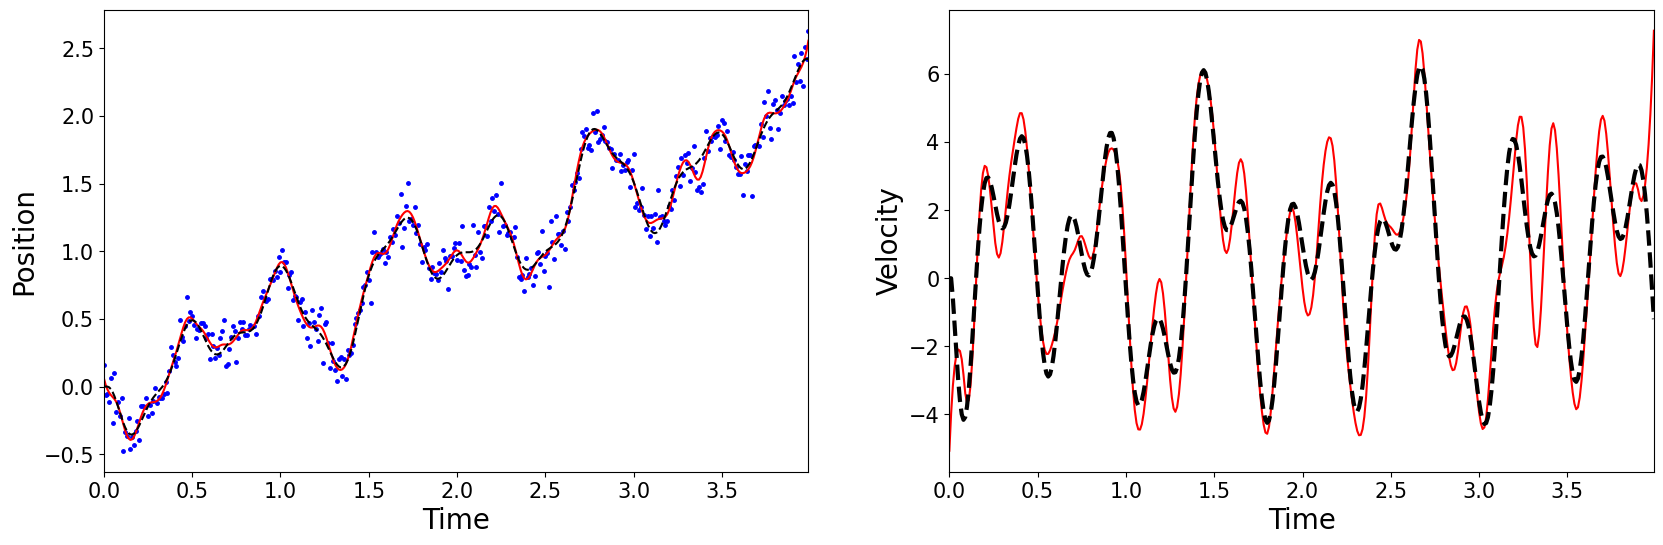

In [24]:
x_hat, dxdt_hat = pynumdiff.linear_model.polydiff(x, dt, poly_order=2, window_size=21)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.3 Linear Models: Savitzky-Golay filter

RMS error in velocity:  0.9090077629537203


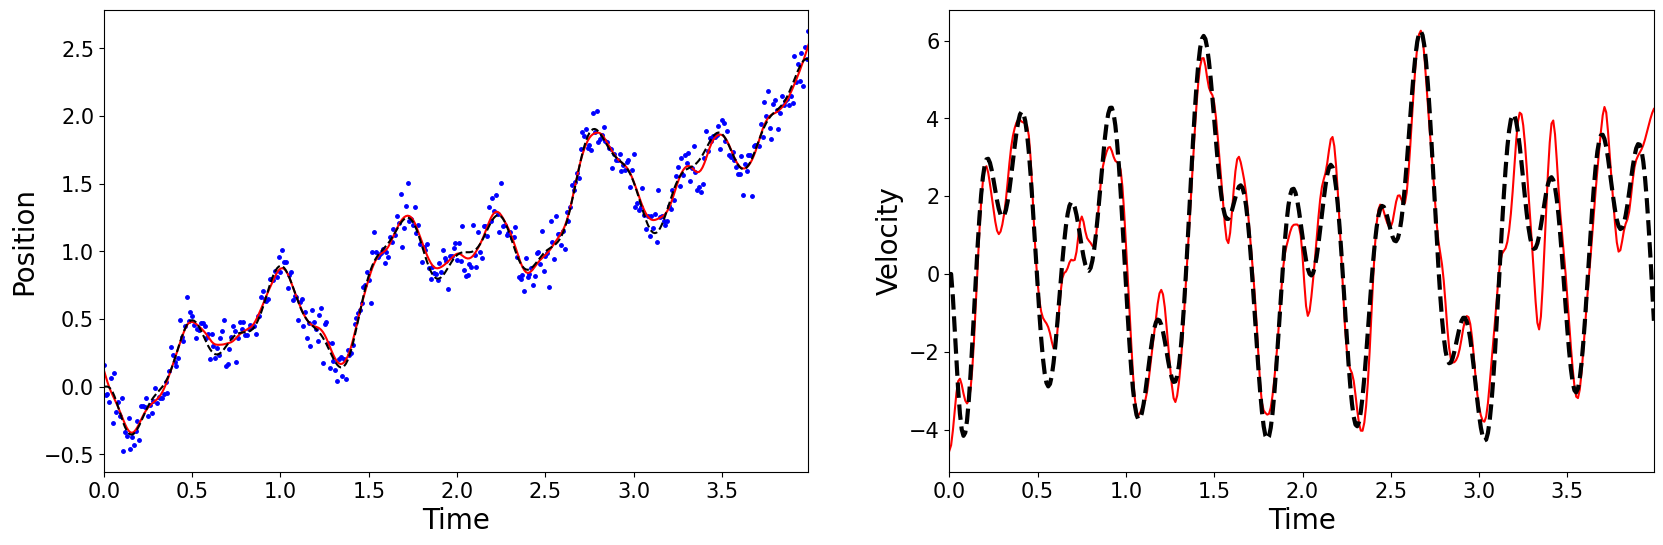

In [25]:
x_hat, dxdt_hat = pynumdiff.linear_model.savgoldiff(x, dt, poly_order=2, window_size=10, smoothing_win=10)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.5 Linear Models: Sliding linear time invariant system fit

/usr/local/lib/python3.13/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


RMS error in velocity:  1.1914757948953194


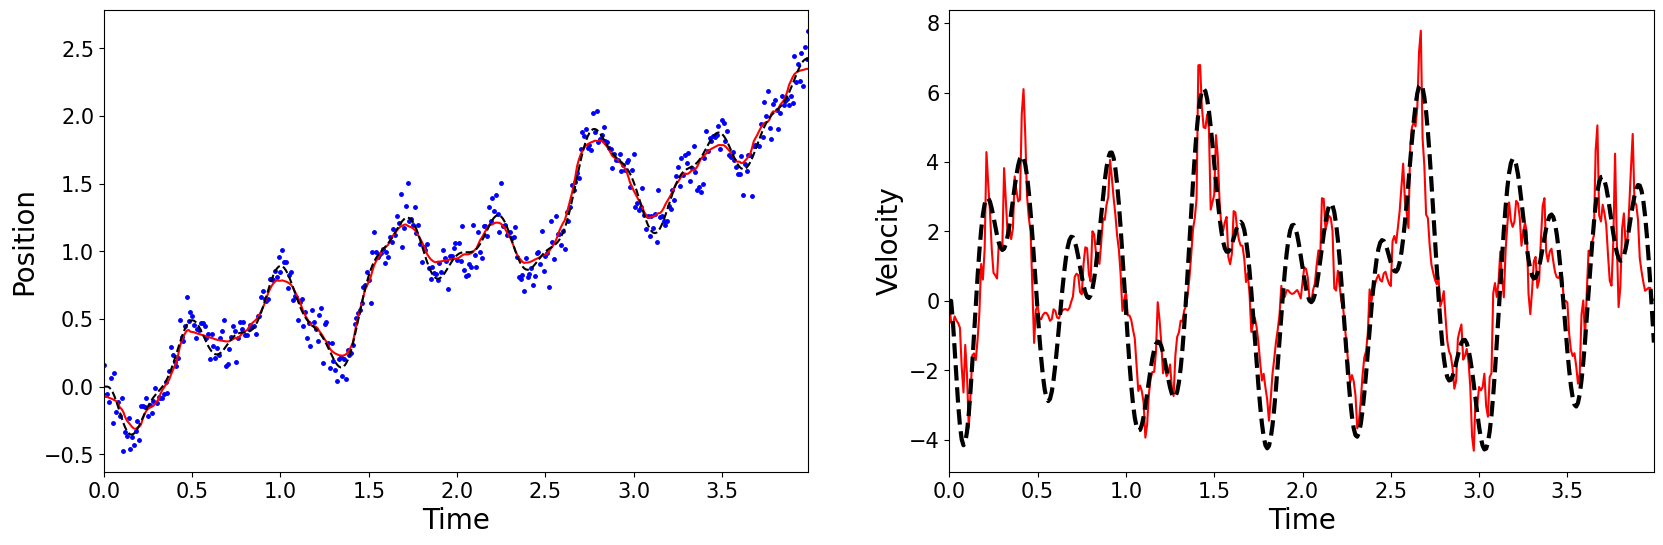

In [26]:
x_hat, dxdt_hat = pynumdiff.linear_model.lineardiff(x, dt, order=3, gamma=10, window_size=21)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## Kalman smoothing

### 5.1 Kalman smoothing: constant velocity (forward-backward)

RMS error in velocity:  0.7425637093650218


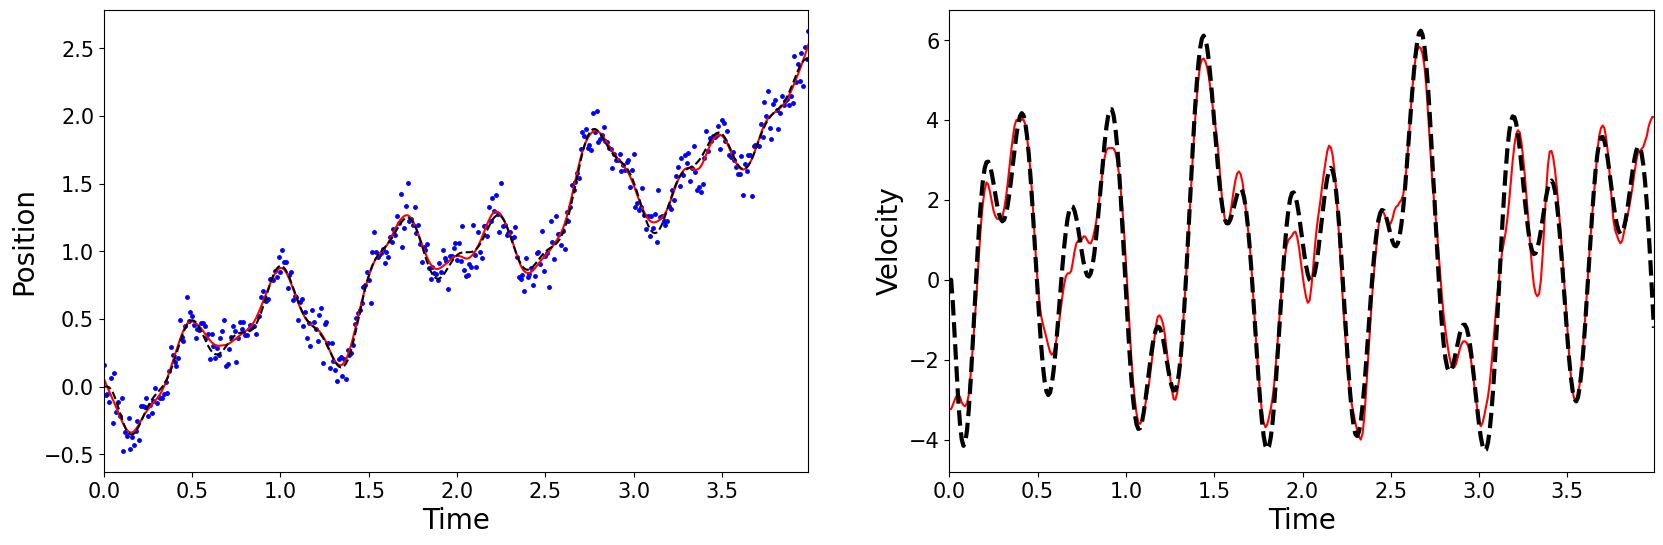

In [27]:
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_velocity(x, dt, r=noise_parameters[1]**2, q=1)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.2 Kalman smoothing: constant acceleration (forward-backward)

RMS error in velocity:  0.7614915464402138


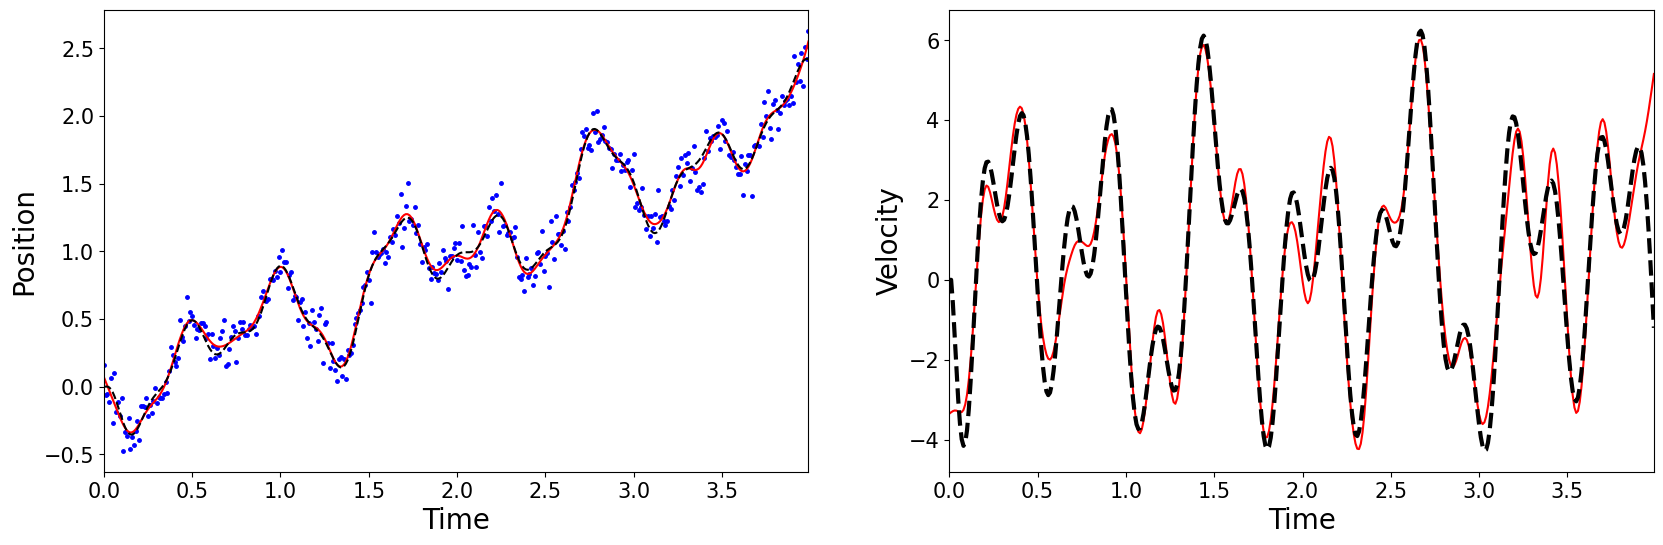

In [28]:
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_acceleration(x, dt, r=noise_parameters[1]**2, q=1e3)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.3 Kalman smoothing: constant jerk (forward-backward)

RMS error in velocity:  0.724816302052431


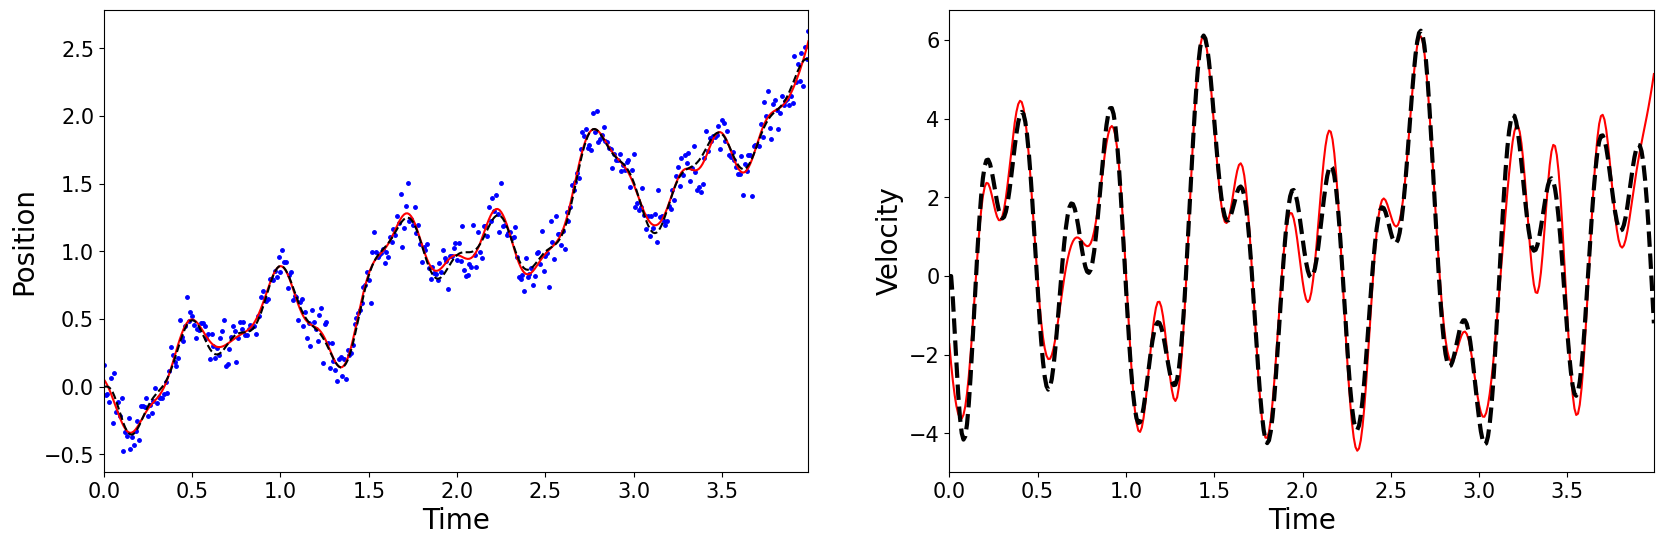

In [29]:
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_jerk(x, dt, r=noise_parameters[1]**2, q=1e6)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)